In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
DATA_DIR = './'

TRAIN_DIR = f'{DATA_DIR}/train'
TEST_DIR = f'{DATA_DIR}/test'

PLOTS_DIR = f'{DATA_DIR}/plots'

OUTPUT_DIR = f'{DATA_DIR}/output'
MODEL_CHECKPOINT_DIR = f'{DATA_DIR}/models'

## Base Model

### Preprocessing

In [3]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=RuntimeWarning)
tqdm.pandas()

In [4]:

train = pd.read_csv(f'{TRAIN_DIR}/Train.csv')
desc = pd.read_csv(f'{DATA_DIR}/DataDictionary.csv')

In [5]:

CAT = desc[36:]['Column Name'].tolist()
train_df = train.drop(columns=CAT)

In [6]:
rel_feat_cols = [c for c in train_df.columns if c not in ['sku_name', 'month', 'year']
             and all(l not in c for l in ['target', 'channel'])]

relative_cols = [f'rel_{col}' for col in rel_feat_cols]

In [7]:
train_df[relative_cols] = train_df.groupby(['month','year'])[rel_feat_cols].apply(lambda x: x/x.median())
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [8]:
from fossil.preprocessing import FossilPreprocessor, LabelEncoder
from fossil.config import ModelsConfig

np.random.seed(ModelsConfig.SEED)
sku_encoder = LabelEncoder(train.sku_name.sample(frac=0.95, random_state=ModelsConfig.SEED).unique())

dates_unsorted = [(m, y) for y,m in train_df.groupby(['year', 'month']).groups.keys()]
dates = sorted(dates_unsorted, key=lambda d: (d[1], d[0]))


In [9]:
train_data = train_df.copy()

feature_cols = [c for c in train_data.columns if c not in ['sku_name', 'month', 'year']
             and all(l not in c for l in ['target', 'channel','rel'])]

fossil_preproc = FossilPreprocessor(sku_encoder)
train_data = fossil_preproc.extract_primary_features(train_data, feature_cols, dates)

  0%|          | 0/3868 [00:00<?, ?it/s]

  0%|          | 0/3868 [00:00<?, ?it/s]

  0%|          | 0/3868 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3868 [00:00<?, ?it/s]

In [10]:

train_data['sku_coded'] = train_data['sku_name'].apply(sku_encoder)
train_data = train_data.groupby(['month','year']).progress_apply(fossil_preproc.clean_data).reset_index(drop=True)

  0%|          | 0/58 [00:00<?, ?it/s]

In [11]:

cols_1 = [c for c in train_data.columns if c not in ['sku_name','sku_coded']]
cols_2 = [c for c in train_data.columns if c not in ['month','year', 'sku_name', 'sku_coded']]

train_data[cols_1] = train_data.groupby('sku_name')[cols_1].progress_transform(lambda x: x.fillna(x.median()))
train_data[cols_2] = train_data.groupby(['month','year'])[cols_2].progress_transform(lambda x: x.fillna(x.median()))

  0%|          | 0/3868 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

### Feature Selection using PCA

In [12]:
from sklearn.preprocessing import StandardScaler
features = [c for c in train_data.columns if all(l not in c for l in ['sku_name','sku_coded','target'])] 
scaler = StandardScaler()
scaled_features = scaler.fit_transform(train_data[features])

In [13]:
from sklearn.decomposition import PCA

pca = PCA(random_state=ModelsConfig.SEED)
feat_pca = pca.fit(scaled_features)

Text(0, 0.5, 'cumulative explained variance')

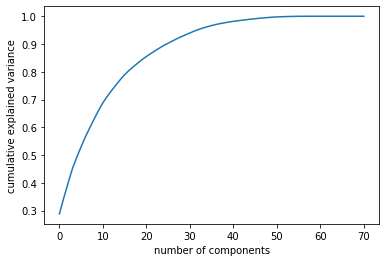

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [15]:
num_components = 50
pca = PCA(num_components, random_state=ModelsConfig.SEED)
feat_pca = pca.fit_transform(scaled_features)

In [16]:
feat_importance = pd.DataFrame(pca.components_, columns = train_data[features].columns)

In [17]:
n_pcs = pca.n_components_
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = train_data[features].columns
most_important_cols = list(set([initial_feature_names[most_important[i]] for i in range(n_pcs)]))

### Model Training

In [18]:
from fossil.models.gbdt import FossilGBDT

In [19]:
gbdt_models = FossilGBDT()

In [20]:
cols = most_important_cols+['sku_name','sku_coded', 'month', 'year']
feature_cols = [c for c in train_data.columns if c in most_important_cols+['sku_name','sku_coded', 'month', 'year']]
target_cols = [c for c in train_data.columns if 'target' in c]

base_cv_models = gbdt_models.train_model(train_data, feature_cols, target_cols, True, 
                                         True, False, model_type=ModelsConfig.BASE_MODEL)

Training model for timestep 1 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[262]	training's l1: 108778	valid_1's l1: 153917


Training fold 2
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 88193.6	valid_1's l1: 118949
Early stopping, best iteration is:
[663]	training's l1: 80184.4	valid_1's l1: 117452


Training fold 3
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 86116.1	valid_1's l1: 129129
Early stopping, best iteration is:
[590]	training's l1: 81433	valid_1's l1: 128136
Elapsed 0.16 mins
--------------------------------------------------


Training model for timestep 2 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[415]	training's l1: 89253.5	valid_1's l1: 152350


Training fold 2
Training until validation scores don't improve for 5 rounds
[500]	training's l

In [21]:
base_val_mae, base_oof = gbdt_models.test_model(train_data, feature_cols, target_cols, base_cv_models)

Making timestep 1 predictions
Val MAE: 133327.43375634175


Making timestep 2 predictions
Val MAE: 137423.6515245171


Making timestep 3 predictions
Val MAE: 131621.4255554171


Making timestep 4 predictions
Val MAE: 126127.07988322784


Average Val MAE: 132124.89767987368


## Meta Learner

### Data Prep

In [22]:
target_cols = [f'target_{i}' for i in range(ModelsConfig.N_STEPS)]
pred_cols = [f'preds_{i}' for i in range(ModelsConfig.N_STEPS)]

In [23]:
train_meta = train_data.copy()
train_meta[pred_cols] = base_oof

In [24]:
target_arr = train_meta[target_cols].values.reshape(-1,1)
pred_arr = train_meta[pred_cols].values.reshape(-1,1)

In [25]:
train_cols = [c for c in train_meta if c not in target_cols+pred_cols]
train_expanded = train_meta.loc[train_meta.index.repeat(ModelsConfig.N_STEPS)][train_cols].reset_index(drop=True)

train_expanded['target'] = target_arr
train_expanded['preds'] = pred_arr
train_expanded['time_step'] = train_expanded.groupby(['sku_name','month','year']).cumcount()

In [26]:
meta_dates_unsorted = [(m+ModelsConfig.N_STEPS, y) if m+ModelsConfig.N_STEPS<=12 
                       else (m+ModelsConfig.N_STEPS-12, y+1)
                       for y,m in train_expanded[['year','month']].apply(tuple, axis=1)]

meta_dates = sorted(meta_dates_unsorted, key=lambda d: (d[1], d[0]))

In [27]:
train_expanded[['month','year']] = pd.DataFrame(meta_dates, columns=['month','year'])

### Model Training

In [28]:
cols = ['sku_name','sku_coded','preds', 'time_step', 'month', 'year']
meta_features = [c for c in train_expanded.columns if 'lag' in c or c in cols]
meta_targets = 'target'

meta_cv_models = gbdt_models.train_model(train_expanded, meta_features, meta_targets, False, False, 
                                         False, model_type=ModelsConfig.META_LEARNER,  model_level='meta')



Training fold 1
0:	learn: 204237.7583625	test: 204237.7583625	test1: 222888.0780851	best: 222888.0780851 (0)	total: 54.7ms	remaining: 9m 6s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 129479.5046
bestIteration = 384

Shrink model to first 385 iterations.
Elapsed 0.07 mins
--------------------------------------------------




Training fold 2
0:	learn: 208648.0555209	test: 208648.0555209	test1: 213429.4316487	best: 213429.4316487 (0)	total: 9.56ms	remaining: 1m 35s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 117641.699
bestIteration = 340

Shrink model to first 341 iterations.
Elapsed 0.14 mins
--------------------------------------------------




Training fold 3
0:	learn: 217960.4751623	test: 217960.4751623	test1: 194672.1233600	best: 194672.1233600 (0)	total: 9.14ms	remaining: 1m 31s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 111963.7248
bestIteration = 272

Shrink model to first 273 iterations.
Elapsed 0.19 mins
--

In [29]:
meta_val_mae, meta_oof = gbdt_models.test_model(train_expanded, meta_features, meta_targets,
                                      meta_cv_models, False, False)



Making fold 1 predictions
Val MAE: 129479.50464775




Making fold 2 predictions
Val MAE: 117641.6990042723




Making fold 3 predictions
Val MAE: 111963.72478919323


Average Val MAE: 119767.48921147245


## Blending

## Inference

### Data Prep

In [30]:

test = pd.read_csv(f'{TEST_DIR}/Test.csv')
train = pd.read_csv(f'{TRAIN_DIR}/Train.csv')
desc = pd.read_csv(f'{DATA_DIR}/DataDictionary.csv')

CAT = desc[36:]['Column Name'].tolist()
train_df = train.drop(columns=CAT)

In [31]:
from fossil.config import ModelsConfig
from fossil.preprocessing import FossilPreprocessor, LabelEncoder

np.random.seed(ModelsConfig.SEED)
sku_encoder = LabelEncoder(train.sku_name.sample(frac=0.95).unique())
fossil_preproc = FossilPreprocessor(sku_encoder)

In [32]:
rel_feat_cols = [c for c in train_df.columns if c not in ['sku_name', 'month', 'year']
             and all(l not in c for l in ['target', 'channel'])]

relative_cols = [f'rel_{col}' for col in rel_feat_cols]

In [33]:
train_df[relative_cols] = train_df.groupby(['month','year'])[rel_feat_cols].apply(lambda x: x/x.median())
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [34]:
dates = sorted([(m, y) for y,m in test.groupby(['year', 'month']).groups.keys()], key=lambda d: (d[1], d[0]))

month,yr = dates[0]
test_dates = [(month-n,yr) if month>n else (12+month-n, yr-1) for n in range(1,ModelsConfig.LOOKBACK+1)]

m,y = test_dates[0]
pred_dates = [(m+n,yr) if m+n<=12 else (m+n-12, yr+1) for n in range(1,ModelsConfig.N_STEPS+1)]

test_context = train_df.copy()

In [35]:
from fossil.inference import add_missing_context

test_sku = test.sku_name.unique()
context_sku = test_context[test_context[['month', 'year']].apply(tuple, axis=1).isin(test_dates)].sku_name.unique()

missing_sku = list(set(test_sku).difference(context_sku))
test_context = test_context.groupby(['month','year']).apply(add_missing_context, missing_sku=missing_sku).reset_index(drop=True)

In [36]:
feature_cols = [c for c in test_context.columns if c not in ['sku_name', 'month', 'year']
             and all(l not in c for l in ['target', 'channel','rel'])]

test_data = fossil_preproc.extract_primary_features(test_context, feature_cols, dates)

test_data['sku_coded'] = test_data['sku_name'].apply(sku_encoder)
test_data = test_data.groupby(['month','year']).progress_apply(fossil_preproc.clean_data).reset_index(drop=True)

  0%|          | 0/3869 [00:00<?, ?it/s]

  0%|          | 0/3869 [00:00<?, ?it/s]

  0%|          | 0/3869 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3869 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

In [37]:

cols_1 = [c for c in test_data.columns if c not in ['sku_name','sku_coded']]
cols_2 = [c for c in test_data.columns if c not in ['month','year','sku_name','sku_coded']]

test_data[cols_1] = test_data.groupby('sku_name')[cols_1].progress_transform(lambda x: x.fillna(x.median()))
test_data[cols_2] = test_data.groupby(['month','year'])[cols_2].progress_transform(lambda x: x.fillna(x.median()))

  0%|          | 0/3869 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

In [38]:
test_data = test_data[test_data[['month', 'year']].apply(tuple, axis=1).isin(test_dates)]

In [39]:
test_data

,sku_name,month,year,starting_inventory,sellin,sellin_channel_1,sellin_channel_2,sellin_channel_3,sellin_channel_4,sellin_channel_5,...,sellin_9month_MM,sellout_6month_MM,sellout_9month_MM,onhand_inventory_6month_MM,onhand_inventory_9month_MM,leftover_inventory_6month_MM,leftover_inventory_9month_MM,price_6month_MM,price_9month_MM,sku_coded
37061,ABEAHAMASHL,10.0,2021.0,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,29377.0,39507.00,35455.0,229444.50,291744.0,-13675.5,-16208.0,149.0,149.0,74.0
37062,ABEANNAONEIZZ,10.0,2021.0,168158.0,76988.0,0.0,10130.0,0.0,0.0,0.0,...,16208.0,26844.50,31403.0,75468.50,176262.0,-8104.0,-9117.0,129.0,129.0,2241.0
37063,ABEENNEARMAZZ,10.0,2021.0,42546.0,152963.0,58754.0,35455.0,0.0,0.0,0.0,...,230964.0,148911.00,97248.0,695931.00,600709.0,68884.0,106365.0,129.0,129.0,633.0
37064,ABEETTEABE,10.0,2021.0,3352017.0,1211548.0,1095053.0,61793.0,0.0,0.0,0.0,...,856998.0,239574.50,275536.0,2851088.50,2452473.0,534357.5,490292.0,159.0,159.0,789.0
37065,ABERTHAKEVAZZ,10.0,2021.0,2366368.0,749620.0,729360.0,15195.0,0.0,0.0,0.0,...,56728.0,29630.25,40520.0,166385.25,253250.0,5571.5,8104.0,132.0,129.0,3640.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37697,YOSHLANDJULIZZ,10.0,2021.0,45585.0,3039.0,0.0,0.0,0.0,0.0,0.0,...,56728.0,29630.25,40520.0,166385.25,253250.0,5571.5,8104.0,132.0,129.0,1663.0
37698,YOSHLEENBART,10.0,2021.0,1664359.0,111430.0,67871.0,31403.0,0.0,0.0,0.0,...,237042.0,40520.00,48624.0,234509.50,251224.0,171703.5,141820.0,129.0,129.0,725.0
37699,YOSHLONAWHITZZ,10.0,2021.0,9117.0,1013.0,0.0,0.0,0.0,0.0,0.0,...,56728.0,2026.00,40520.0,9117.00,253250.0,1519.5,8104.0,99.0,129.0,2714.0
37700,YOSHRENECARL,10.0,2021.0,1527604.0,288705.0,199561.0,79014.0,0.0,0.0,0.0,...,338342.0,110923.50,117508.0,738983.50,793179.0,211717.0,214756.0,129.0,129.0,248.0


### Forecasting

In [42]:
target_cols = [f'target_{i}' for i in range(ModelsConfig.N_STEPS)]

cols = most_important_cols+['month','year']
non_features = ['sku_name','sku_coded']+target_cols
feature_cols = [c for c in test_data.columns if c not in non_features and c in cols]

In [43]:
from fossil.models.gbdt import FossilGBDT
gbdt_models = FossilGBDT()

base_preds = gbdt_models.forecast(test_data, feature_cols, target_cols, base_cv_models, True, True, True)

In [44]:
if ModelsConfig.LOOKBACK>1:
    pred_df = pred_df.groupby(['sku_name','lookback_ix']).mean().reset_index()    

In [45]:
base_preds = base_preds[base_preds.sku_name.isin(test.sku_name.unique())]
pred_arr = base_preds[target_cols].values.reshape(-1,1)

sub_cols = [c for c in train_cols if 'target' not in c]
sub_df = base_preds.loc[base_preds.index.repeat(ModelsConfig.N_STEPS)][sub_cols].reset_index(drop=True)


sub_df['month'] = pd.DataFrame(pred_dates*int(len(sub_df)/ModelsConfig.N_STEPS)).loc[:, 0].values
sub_df['year'] = pd.DataFrame(pred_dates*int(len(sub_df)/ModelsConfig.N_STEPS)).loc[:, 1].values

sub_df['preds'] = pred_arr
sub_df['time_step'] = sub_df.groupby(['sku_name','month','year']).cumcount()

In [46]:
cols = ['preds', 'time_step', 'month', 'year']
meta_features = [c for c in sub_df.columns if 'lag' in c or c in cols]
meta_targets = 'Target'

sub_df = gbdt_models.forecast(sub_df, meta_features, meta_targets, meta_cv_models, True, False, False)

sub_df['Item_ID'] = sub_df['sku_name'].astype(str)+'_'+sub_df['month'].astype(str)+'_'+sub_df['year'].astype(str)

In [ ]:
save_name = f'{OUTPUT_DIR}/fossil_{ModelsConfig.BASE_MODEL}_{ModelsConfig.META_LEARNER}_{meta_val_mae}.csv'
sub_df[['Item_ID','Target']].to_csv(save_name, index=False)

In [48]:
sub_df

,sku_name,month,year,starting_inventory,sellin,sellin_channel_1,sellin_channel_2,sellin_channel_3,sellin_channel_4,sellin_channel_5,...,onhand_inventory_9month_MM,leftover_inventory_6month_MM,leftover_inventory_9month_MM,price_6month_MM,price_9month_MM,sku_coded,preds,time_step,Target,Item_ID
0,ABEAHAMASHL,11,2021,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,60861.620384,0,16967.443896,ABEAHAMASHL_11_2021
1,ABEAHAMASHL,12,2021,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,119548.877609,0,46101.277381,ABEAHAMASHL_12_2021
2,ABEAHAMASHL,1,2022,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,111516.271393,0,57592.662009,ABEAHAMASHL_1_2022
3,ABEAHAMASHL,2,2022,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,141192.958922,0,54623.165457,ABEAHAMASHL_2_2022
4,ABEENNEARMAZZ,11,2021,42546.0,152963.0,58754.0,35455.0,0.0,0.0,0.0,...,600709.0,68884.0,106365.0,129.0,129.0,633.0,271209.717640,0,158442.661289,ABEENNEARMAZZ_11_2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1523,YOSHRENECARL,2,2022,1527604.0,288705.0,199561.0,79014.0,0.0,0.0,0.0,...,793179.0,211717.0,214756.0,129.0,129.0,248.0,297539.908797,0,191482.389197,YOSHRENECARL_2_2022
1524,YOSHTLYNYOSHZZ,11,2021,156002.0,163093.0,122573.0,30390.0,0.0,0.0,0.0,...,193483.0,180820.5,200574.0,149.0,149.0,1852.0,247889.118353,0,145992.882929,YOSHTLYNYOSHZZ_11_2021
1525,YOSHTLYNYOSHZZ,12,2021,156002.0,163093.0,122573.0,30390.0,0.0,0.0,0.0,...,193483.0,180820.5,200574.0,149.0,149.0,1852.0,264885.004303,0,160257.978087,YOSHTLYNYOSHZZ_12_2021
1526,YOSHTLYNYOSHZZ,1,2022,156002.0,163093.0,122573.0,30390.0,0.0,0.0,0.0,...,193483.0,180820.5,200574.0,149.0,149.0,1852.0,227624.016944,0,160516.300863,YOSHTLYNYOSHZZ_1_2022


In [63]:
sub_df

,sku_name,month,year,starting_inventory,sellin,sellin_channel_1,sellin_channel_2,sellin_channel_3,sellin_channel_4,sellin_channel_5,...,onhand_inventory_9month_MM,leftover_inventory_6month_MM,leftover_inventory_9month_MM,price_6month_MM,price_9month_MM,sku_coded,preds,time_step,Target,Item_ID
0,ABEAHAMASHL,11,2021,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,68493.186385,0,18653.989835,ABEAHAMASHL_11_2021
1,ABEAHAMASHL,12,2021,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,139666.726152,0,46280.487441,ABEAHAMASHL_12_2021
2,ABEAHAMASHL,1,2022,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,125585.440628,0,57740.143400,ABEAHAMASHL_1_2022
3,ABEAHAMASHL,2,2022,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,123148.299105,0,47090.482670,ABEAHAMASHL_2_2022
4,ABEENNEARMAZZ,11,2021,42546.0,152963.0,58754.0,35455.0,0.0,0.0,0.0,...,600709.0,68884.0,106365.0,129.0,129.0,633.0,262311.050127,0,154738.264677,ABEENNEARMAZZ_11_2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1523,YOSHRENECARL,2,2022,1527604.0,288705.0,199561.0,79014.0,0.0,0.0,0.0,...,793179.0,211717.0,214756.0,129.0,129.0,248.0,304326.984856,0,202158.672012,YOSHRENECARL_2_2022
1524,YOSHTLYNYOSHZZ,11,2021,156002.0,163093.0,122573.0,30390.0,0.0,0.0,0.0,...,193483.0,180820.5,200574.0,149.0,149.0,1852.0,244010.740011,0,132271.452093,YOSHTLYNYOSHZZ_11_2021
1525,YOSHTLYNYOSHZZ,12,2021,156002.0,163093.0,122573.0,30390.0,0.0,0.0,0.0,...,193483.0,180820.5,200574.0,149.0,149.0,1852.0,267407.530586,0,178625.461343,YOSHTLYNYOSHZZ_12_2021
1526,YOSHTLYNYOSHZZ,1,2022,156002.0,163093.0,122573.0,30390.0,0.0,0.0,0.0,...,193483.0,180820.5,200574.0,149.0,149.0,1852.0,221509.683499,0,130105.067112,YOSHTLYNYOSHZZ_1_2022
